In [1]:
using Statistics, JLD2

In [78]:
#Used for loading Phys data
using PyCall
pyABF = pyimport("pyabf")

PyObject <module 'pyabf' from 'C:\\Users\\mtarc\\Anaconda3\\envs\\RetinalWaves\\lib\\site-packages\\pyabf\\__init__.py'>

In [79]:
#using DifferentialEquations
using Plots, Colors, LaTeXStrings, StatsPlots
using Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

#Define different symbols used in the plotting
delta = latexstring("\$\\delta\$")
micro = latexstring("\$\\mu\$")
vt = latexstring("\$V_t\$")
nt = latexstring("\$N_t\$")
bt = latexstring("\$B_t\$")
wt = latexstring("\$W_t\$")
i_ach = latexstring("\$I_{ACh}\$")

v_color = :deepskyblue
n_color = :magenta
c_color = :green
a_color = :purple
b_color = :red
e_color = :blue
w_color = :gray
phys_color = :black

figure_path = "C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

"C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

In [80]:
#Logging for 2D simulations
using Logging, TerminalLoggers
global_logger(TerminalLogger());

In [81]:
#Import all the functions for extracting parameters
import RetinalChaos: read_JSON, extract_dict 
import RetinalChaos: tar_conds, tar_pars
import RetinalChaos: calculate_threshold, count_intervals, timescale_analysis, get_timestamps, max_interval_algorithim
import RetinalChaos: SOSRI, SDEProblem, solve
import RetinalChaos: T_sde, noise_2D
import RetinalChaos: parse_abf, extract_abf
import RetinalChaos: Network

## Table of contents:

### [0] Introduction to RetinalChaos.jl

### [1] Methods
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### _**[2] Analyzing Data Output of the model**_
#### [2.1] Time Scale Analysis
#### [2.2] **Fitting Experimental Data (Patch)**
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers
#### [3.x] Dynamical Analysis

### Optimizing current Models

- We have so far established a acceptable model to characterize the neuronal firing of starburst amacrine cells, and established a method to quantify the timescales within the cells firing. 
- Our goal is to measure how closely our model and quantification is related to actual data including 

##### We can use data collected from whole cell patch clamp to quantify how closely our data matches 

### [2.2.a] Loading Physiological Data from .abf files
- All physiological traces were obtained in ClampEx
- The first thing we have to do is to load the .abf file.

In [82]:
target_folder = "D:\\2019_Renna Lab\\Data\\Patching\\"
target_file = "D:\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"
#Load experimental data
exp_data = pyABF.ABF(target_file)
println("File successfully loaded")
#Extract the time trace, and the 
t = exp_data.sweepX
dt_exp = t[2]
aq = 1/dt_exp
println("Data from time stamp $(t[1]) s to $(t[end]+dt_exp) s with dt = $dt_exp s")
println("Data was acquired at $aq Hz")
println("$(length(t)) data points")

File successfully loaded
Data from time stamp 0.0 s to 300.0 s with dt = 5.0e-5 s
Data was acquired at 20000.0 Hz
6000000 data points


##### Analyzing the data before loading into Julia. 
- It may be helpful to look over data before loading it into the Julia interface. 
- with 300s at 20kHz you will have 6 million data points. This can cause some overhead memory issues. 
- In this specific recording, we only care about 100s (from 130-230s). 

In [83]:
#In order to account for Junction potentials we can add an offset
v_offset = -25.0
#Extract the 1st sweep 1st channel from the .abf file
exp_data.setSweep(sweepNumber = 0, channel = 0);
#Vm is the raw data
vm = Float64.(exp_data.sweepY);
#We reduce the data to 100k data points between 120-_230s for memory saving and graphing. 
reduced = round.(Int, LinRange(Int(130/dt_exp), Int(230/dt_exp), Int(100e3)));
#For some graphing purposes, we reset the timestamps (keeping t as the original)
t_offset = (t[reduced] .- t[reduced][1]).*1000;
#The new interval should be 1ms or 1kHz
dt_sim = round(t_offset[2]-t_offset[1], digits = 2)
println("Reduced data acquisition $dt_sim")

Reduced data acquisition 1.0


In [84]:
#We have two traces:
#2) Normal for data analysis, but slow graphing with the orginal interval
Vm_trace = vm[Int(130/dt_exp):Int(230/dt_exp)].+v_offset;
#1) Reduced for quicker graphing with an interval of 1ms
Vm_trace_RED = vm[reduced].+v_offset;

### [2.2.b] Timescale analysis
- As described in the previous notebook, we can extend the quantification methods used to analyze the simulation. 

In [85]:
threshold = calculate_threshold(Vm_trace);
println("The spiking threshold = $(round(threshold, digits = 2)) mV")
spike_phys = (Vm_trace .> threshold);
intervals = count_intervals(spike_phys)*dt_exp*1000;
println("$(length(intervals)+1) spiking events have been detected")

The spiking threshold = -53.19 mV
119 spiking events have been detected


In [86]:
maximum(intervals)

43496.450000000004

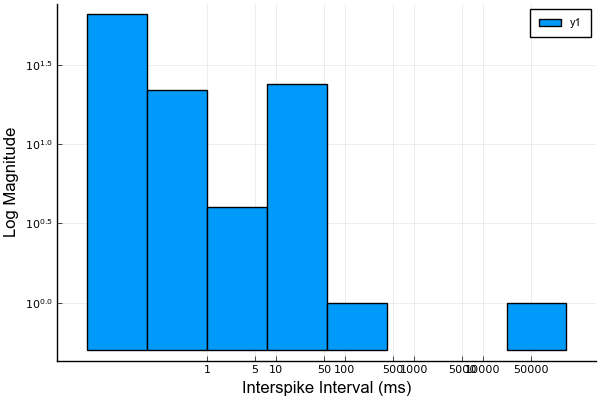

In [87]:
xstops = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000];
xticks = (log.(xstops), xstops);   
histogram(log.(intervals), yaxis = :log, xticks = xticks, ylabel = "Log Magnitude", xlabel = "Interspike Interval (ms)")

In [88]:
#Conducting the analysis in a single function you can use the imported function timescale_analysis
ts_analysis = timescale_analysis(Vm_trace, dt = dt_exp*1000, mode = 2);

In [89]:
ts_analysis

([0.049999999999272404, 0.09999999999854481, 16.200000000000728, 0.049999999999272404, 0.049999999999272404, 12.950000000000728, 12.799999999999272, 14.599999999998545, 0.1500000000014552, 49.0  …  0.35000000000582077, 0.5, 0.05000000000291038, 0.10000000000582077, 0.3000000000029104, 0.05000000000291038, 0.14999999999417923, 0.10000000000582077, 0.05000000000291038, 0.10000000000582077], [677.0999999999549, 690.9000000000524], [43496.450000000004])

### [2.2.c] Visual comparison with simulations. 
- Using the process defined in the previous notebook, we can compare our physiologically obtained data to data that was simulated

In [90]:
p = read_JSON("params.json") |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
dt = 1.0
tspan = (0.0, 300e3);
SDEprob = SDEProblem(T_sde, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time SDEsol = solve(SDEprob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt); 
trace = Array(SDEsol)';

Time it took to simulate 200ms:
  3.394237 seconds (16.61 M allocations: 704.666 MiB)


In [137]:
##Here we can plot the traces against each other, they will not always align well.  
xlims = (0, t_offset[end]); ylims = (-90.0, 0.0)
ellapsed_time = (xlims[end]-xlims[1])/1000
dt_lims = 20e3
xticks = (collect(xlims[1]:dt_lims:xlims[2]), collect(0:(dt_lims/1000):ellapsed_time)); yticks = (collect(ylims[1]:5:ylims[2]))

fig4_A = plot(ylabel = "Voltage (mV)")
plot!(fig4_A, SDEsol, vars = [:v], label = "Model data", 
    lw = 2.0, c = v_color)
plot!(fig4_A, t_offset, Vm_trace_RED, label = "Experimental Data", 
    lw = 2.0, c = phys_color,
    xlims = xlims, xticks = xticks, 
    ylims = ylims, yticks = yticks, 
    legend = :topright, 
    xlabel = "Time (s)"
)
title!(fig4_A, "A", title_location = :left);

In [128]:
#Conducting the analysis in a single function you can use the imported function timescale_analysis
println("Timescale analysis for simulation")
sim_spikes, sim_bursts, sim_IBIs = timescale_analysis(trace[:,1]; dt = dt, mode = 2);
sim_thresh = calculate_threshold(trace[:,1])
println("The spiking threshold = $(round(sim_thresh, digits = 2)) mV")
sim_spike = (trace[:,1] .> sim_thresh);
sim_intervals = count_intervals(sim_spike) .*dt;
println("$((sim_intervals|>length)+1) spiking events have been detected")

Timescale analysis for simulation
The spiking threshold = -38.32 mV
429 spiking events have been detected


In [129]:
println("Timescale analysis for physiological trace")
exp_spikes, exp_bursts, exp_IBIs = timescale_analysis(Vm_trace, dt = dt_exp*1000, mode = 2);
exp_thresh = calculate_threshold(Vm_trace)
println("The spiking threshold = $(round(exp_thresh, digits = 2)) mV")
exp_spike = (Vm_trace .> exp_thresh);
exp_intervals = count_intervals(exp_spike) .*dt_exp*1000;
println("$((exp_intervals|>length)+1) spiking events have been detected")

Timescale analysis for physiological trace
The spiking threshold = -53.19 mV
119 spiking events have been detected


### [2.2.d] We can analyze many files in a automated fashion. 
- We need to be able to parse through a file heirarchy and grab not only the patch traces, but regions where the patch traces are decent. 
- Jordan has indicated which recordings are decent. This could help eliminate several traces which are not going to be good. 

In [17]:
target_folder = "D:\\Data\\Jordans_Patch_Data\\Starburst Recordings\\"
target_file = "D:\\Data\\Patching\\2019_11_03_Patch\\Animal_2\\Cell_3\\19n03042.abf"
analysis_folder = "D:\\Data\\PatchAnalysis\\"
@time paths = target_folder |> parse_abf;
println(length(paths))

  0.111184 seconds (41.06 k allocations: 2.107 MiB)
117


In [18]:
function extract_abf(abf_path; verbose = false, v_offset = -25.0)
    if length(abf_path |> splitpath) > 1
        full_path = abf_path
    else
        full_path = joinpath(pwd(), abf_path)   
    end
    #extract the abf file by using pyABF
    exp_data = pyABF.ABF(full_path)
    #if the data is segmented into sweeps (which Jordans data is) concatenate all sweeps
    if length(exp_data.sweepList) > 1
        data = Float64[]
        time = Float64[]
        previous_time = 0.0
        for sweepNumber in exp_data.sweepList
            exp_data.setSweep(sweepNumber = sweepNumber, channel = 0);
            push!(data, exp_data.sweepY...);
            push!(time, (exp_data.sweepX.+previous_time)...);
            previous_time = time[end]
        end
        dt = time[2]*1000 #Convert it from ms to s
    else
        exp_data.setSweep(sweepNumber = 0, channel = 0);
        data = Float64.(exp_data.sweepY);
        time = Float64.(exp_data.sweepX);
        dt = time[2]*1000
        
    end
    if verbose
        println("Data extracted from $full_path")
        println("Data from time stamp $(t[1]) s to $(t[end]+dt) s with dt = $dt ms")
        println("Data was acquired at $(1/dt/1000) Hz")
        println("$(length(t)) data points")
    end
    data, time, dt
end

extract_abf (generic function with 1 method)

In [43]:
baselines = [];
mins = [];
maxs = [];
spike_durs = Float64[];
burst_durs = Float64[];
IBIs = Float64[];
save_validation = false

@time for (i, path) in enumerate(paths)
    #println(i)
    
    #Save the validation plots for later
    vm_trace, time, dt_exp = extract_abf(path; verbose = false);
    thresh = calculate_threshold(vm_trace);
    spike_trace = (vm_trace .> thresh);
    title_label = splitpath(path)[end][1:end-4]
    if save_validation
        
        p = plot(time, vm_trace, 
            xlabel = "Time (s)", ylabel = "Membrane Potential (mV)", label = "", 
            xticks = (collect(time[1]:10:time[end]), collect(time[1]:10:time[end])),
            size = (10000,1000))
        if sum(spike_trace) != 0
            burst_stamps, nothing, nothing, nothing = max_interval_algorithim(spike_trace; dt = dt_exp)
            for (rng_s, rng_e) in burst_stamps
                vspan!(p, [rng_s/1000, rng_e/1000], alpha = 0.4, c = :red)
            end
        end
        title!(p, title_label)
        savefig(joinpath(analysis_folder, "Validation_$(title_label).png"))
    end
    
    #Conduct the timescale analysis
    ts_analysis = timescale_analysis(vm_trace, dt = dt_exp, mode = 2);
    println(title_label)
    println(maximum(ts_analysis[1]))
    push!(maxs, maximum(vm_trace))
    push!(mins, minimum(vm_trace))
    push!(spike_durs, ts_analysis[1]...)
    push!(burst_durs, ts_analysis[2]...)
    push!(IBIs, ts_analysis[3]...)
end

11227000
2046.8270468270493
11227001
523.661023661025
11227002
440.1049401049386
11227003
356.69735669734655
11227004
341.8968418968143
11227005
236.4122364122304
11227006
642.8571428571595
11227007
1657.85565785566
11227008
1075.141075141073
11227009
1208.5932085932072
11227010
1572.270072270072
11227011
NaN
11228000
1015.0975150975282
11228001
787.8922878922895
11228002
362.8848628848791
11228003
1479.7544797544797
11228004
1281.7542817542853
11228005
144.49064449064463
11228006
NaN
11228007
NaN
11301000
NaN
11301001
NaN
11301002
NaN
11301003
NaN
11301004
1945.3519453519257
11301005
1316.0578160578152
11301006
NaN
11301007
321.50282150279963
11301008
266.8052668052551
11301009
172.60667260666378
11301010
1168.59716859716
11301011
308.13780813780613
11301012
93.30759330757428
11301013
9.009009009008878
11301014
49.252549252531026
11301015
89.89208989206236
11829000
NaN
11829001
NaN
11829002
NaN
11829003
114.14711414714111
11829004
216.51321651320904
11829005
716.958716958703
11829006


In [54]:
#Remove any NaN values
spike_durs = spike_durs[spike_durs .|> !isnan];
#We seem to have random spikes that are over a certain number. Not really sure how they got there. 
#Spikes longer than 25ms are not spikes
spike_durs_filt = spike_durs[spike_durs .< 10.0]
burst_durs = burst_durs[burst_durs .|> !isnan];
IBIs = IBIs[IBIs .|> !isnan];

This is the output from running the entire analysis on the patch files. 

In [56]:
mean_max = sum(maxs)/length(maxs)
std_max = std(maxs)
mean_min = sum(mins)/length(mins)
std_min = std(mins)
mean_spike_dur = sum(spike_durs_filt)/length(spike_durs_filt)
std_spike_dur = std(spike_durs_filt)
mean_burst_dur = sum(burst_durs)/length(burst_durs)
std_burst_dur = std(burst_durs)
mean_IBI = sum(IBIs)/length(IBIs)
std_IBI = std(IBIs)

37356.43057132812

In [57]:
#println("Mean baseline voltage $(sum(baselines)/length(baselines)) +- $(std(baselines))")
println("Mean max amplitude voltage $mean_max +- $std_min")
println("Mean min amplitude voltage $mean_min +- $std_max")
println("Mean spike duration $mean_spike_dur +- $std_spike_dur")
println("Mean burst duration $(mean_burst_dur/1000) +- $(std_burst_dur/1000)")
println("Mean IBI $(mean_IBI/1000) +- $(std_IBI/1000)")

Mean max amplitude voltage -23.00320934287758 +- 23.348351146685797
Mean min amplitude voltage -65.95082786755684 +- 23.513021216041277
Mean spike duration 0.15899185043482783 +- 0.5563655470167633
Mean burst duration 1.5609921561654478 +- 0.8033678079367412
Mean IBI 66.31729958454098 +- 37.35643057132812


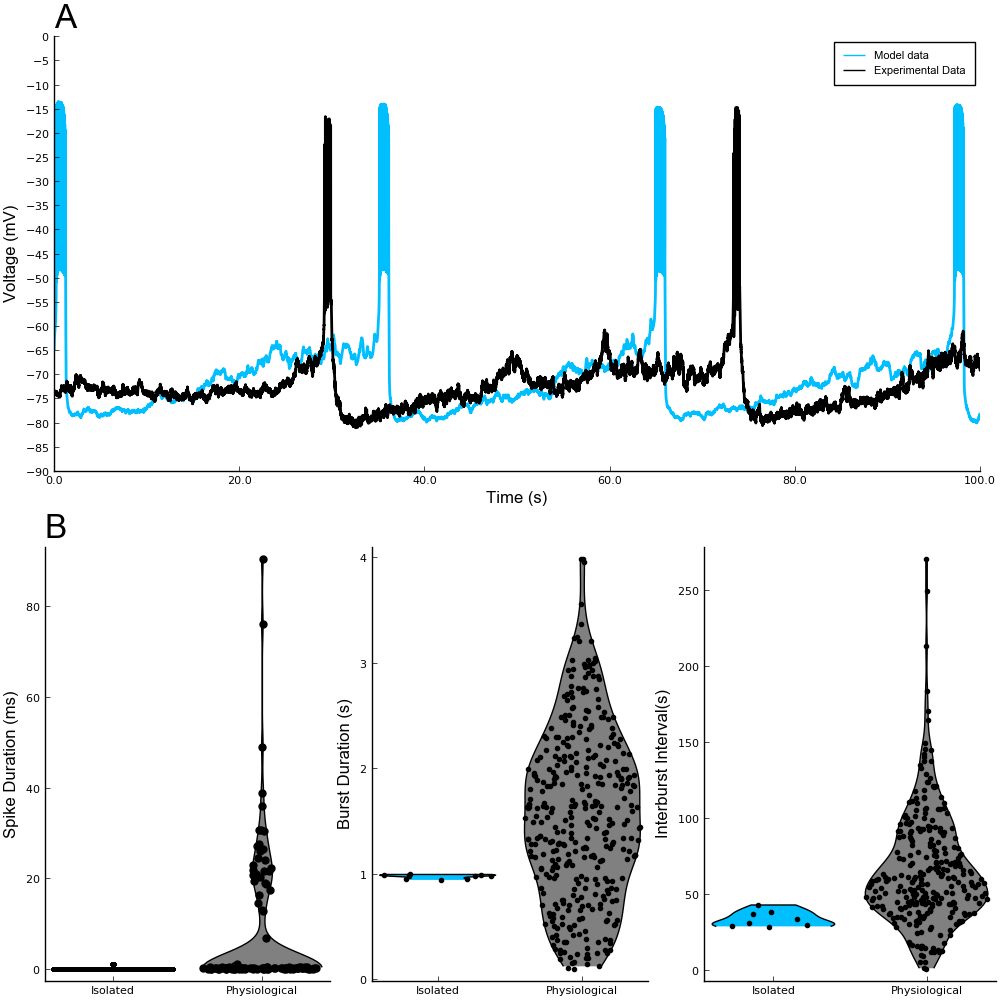

In [140]:
fig4_b1 = violin(sim_spike, label = "", c = v_color, ylabel = "Spike Duration (ms)", xticks = ((1.0, 2.0), ("Isolated", "Physiological")))
dotplot!(fig4_b1, repeat([1.0], length(sim_spike)), sim_spike, label = "", c = :black, markersize = 2.0)
violin!(fig4_b1, repeat([2.0], length(exp_spikes)), exp_spikes, c = :gray, label = "")
dotplot!(fig4_b1, repeat([2.0], length(exp_spikes)), exp_spikes, label = "", c = :black, markersize = 5.0)

fig4_b2 = violin(sim_bursts./1000, label = "", c = v_color, ylabel = "Burst Duration (s)", xticks = ((1.0, 2.0), ("Isolated", "Physiological")))
dotplot!(fig4_b2, repeat([1.0], length(sim_bursts)), sim_bursts./1000, label = "", c = :black, markersize = 3.0)
violin!(fig4_b2, repeat([2.0], length(burst_durs)), burst_durs./1000, c = :grey, label = "")
dotplot!(fig4_b2, repeat([2.0], length(burst_durs)), burst_durs./1000, label = "", c = :black, markersize = 3.0)

fig4_b3 = violin(sim_IBIs./1000, label = "", c = v_color, ylabel = "Interburst Interval(s)", xticks = ((1.0, 2.0), ("Isolated", "Physiological")))
dotplot!(fig4_b3, repeat([1.0], length(sim_IBIs./1000)), sim_IBIs./1000, label = "", c = :black, markersize = 3.0)
violin!(fig4_b3, repeat([2.0], length(IBIs)), IBIs./1000, c = :gray, label = "")
dotplot!(fig4_b3, repeat([2.0], length(IBIs)), IBIs./1000, label = "", c = :black, markersize = 3.0)

fig4_B = plot(fig4_b1, fig4_b2, fig4_b3, layout = grid(1,3), size = (1000, 750))
title!(fig4_B[1], "B", title_pos = :left);

fig4 = plot(fig4_A, fig4_B, layout = grid(2,1), size = (1000,1000), grid = false)

In [139]:
savefig(fig4, "$(figure_path)/Figure4_Physiology_and_Simulation.png")

### [2.2.e] Comparison with wave simulation
- We can load the JLD file from the previous analysis in order to compare statistics to physiological data

In [66]:
function calculate_threshold(filename::String; Z::Int64 = 4)
    JLD2.@load filename tsteps data_size
    nx, ny, npoints = data_size
    n_points = nx*ny*npoints
    avg = 0.0
    covar = 0.0
    thresh = jldopen(filename, "r") do file
        for t in tsteps
            if t%10000==0.0
                #println(t)
            end
            if t == 0.0
                arr = read(file, "$(t)")[:,:,1]
                avg += sum(arr)
            else
                arr = read(file, "$(t)")
                avg += sum(arr)
            end
        end
        #Calculate the average
        avg /= n_points
        println(avg)
        for t in tsteps
            if t%10000==0.0
                #println(t)
            end
            if t == 0.0
                arr = read(file, "$(t)")[:,:,1]
                covar += sum((arr .- avg).^2)
            else
                arr = read(file, "$(t)")
                covar += sum((arr .- avg).^2)
            end
        end
        #Calculate the standard deviation
        std = sqrt(covar/n_points-1)
        #Calculate the threshold
        avg + Z*std
    end
    thresh
end

calculate_threshold (generic function with 2 methods)

In [62]:
ic_loc = "D:\\ModellingData\\trial1\\previous.jld2"
data_loc = "D:\\ModellingData\\trial1\\dataset.jld2"
#JLD2.@load ic_loc ic last_time

"D:\\ModellingData\\trial1\\dataset.jld2"

In [65]:
JLD2.@load data_loc tsteps data_size

2-element Array{Symbol,1}:
 :tsteps
 :data_size

In [67]:
thresh = calculate_threshold(data_loc)

KeyError: KeyError: key "1.0" not found

In [23]:
#Because this file is so huge, we have to do things like this
sim_min_val = 0.0
sim_max_val = 0.0
spike_array = falses(96, 96, 300001) #Preallocate array makes this go faster
sim_baseline = jldopen("test.jld", "r") do file
    sum_vals = 0.0
    for (idx, t) in enumerate(tstamps)
        if t%10000==0.0
            #println(t)
        end
        if t == 0.0
            arr = read(file, "$(t)")[:,:,1]
            sum_vals += sum(arr)
            spike_array[:,:,idx] .= (arr .> thresh)
        else
            arr = read(file, "$(t)")
            sum_vals += sum(arr)
            spike_array[:,:,idx] .= (arr .> thresh)
        end
    end
    sum_vals/length(spike_array)
end;

In [24]:
sim_spike_durs, sim_burst_durs, sim_IBIs = timescale_analysis(spike_array; dt = 1.0, mode = 2);

In [25]:
sim_mean_spike_dur = sum(sim_spike_durs)/length(sim_spike_durs)
sim_std_spike_dur = std(sim_spike_durs)
sim_mean_burst_dur = sum(sim_burst_durs)/length(sim_burst_durs)
sim_std_burst_dur = std(sim_burst_durs)
sim_mean_IBI = sum(sim_IBIs)/length(sim_IBIs)
sim_std_IBI = std(sim_IBIs)

6345.230725168582

In [26]:
n_display = 50
n_spikes_sim = length(sim_spike_durs);
n_bursts_sim = length(sim_burst_durs);
n_ibis_sim = length(sim_IBIs);
rand_spikes = rand(collect(1:n_spikes_sim), n_display);
rand_bursts = rand(collect(1:n_bursts_sim), n_display);
rand_ibis = rand(collect(1:n_ibis_sim), n_display);

In [27]:
println("Mean baseline voltage $(sum(baselines)/length(baselines)) +- $(std(baselines))")
println("Mean max amplitude voltage $sim_mean_max +- $std_min")
println("Mean min amplitude voltage $sim_mean_min +- $std_max")
println("Mean spike duration $sim_mean_spike_dur +- $sim_std_spike_dur")
println("Mean burst duration $(sim_mean_burst_dur/1000) +- $(sim_std_burst_dur/1000)")
println("Mean IBI $(sim_mean_IBI/1000) +- $(sim_std_IBI/1000)")

UndefVarError: UndefVarError: sim_mean_max not defined

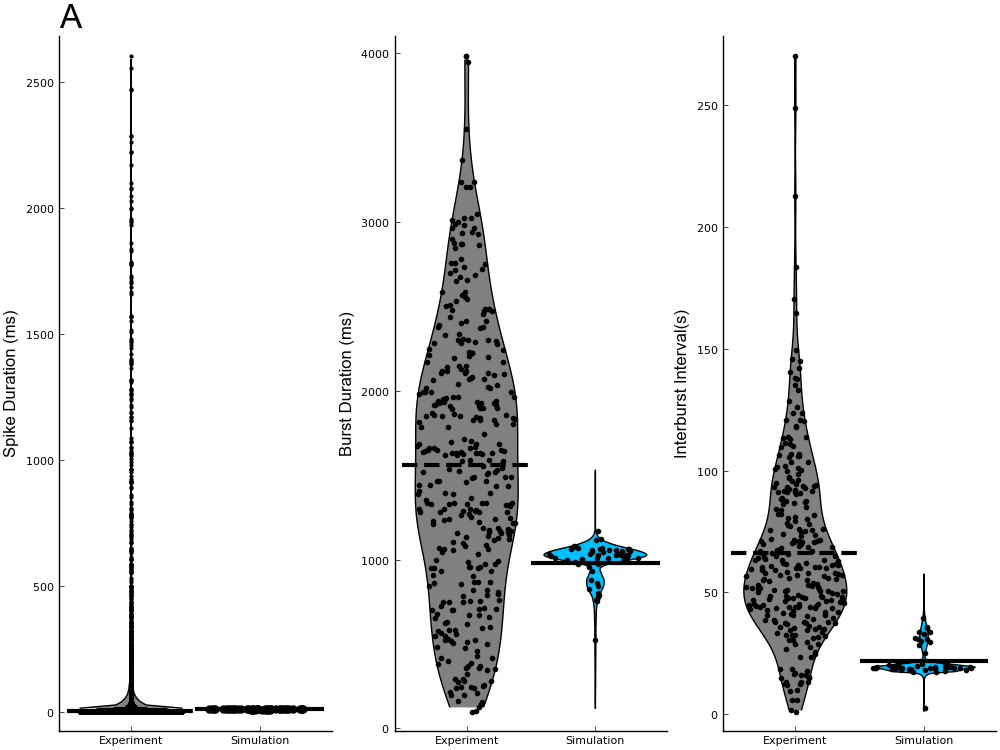

In [18]:
fig4_b1 = violin(spike_durs, label = "", c = :gray, ylabel = "Spike Duration (ms)", xticks = ((1.0, 2.0), ("Experiment", "Simulation")))
dotplot!(fig4_b1, repeat([1.0], length(spike_durs)), spike_durs, label = "", c = :black, markersize = 2.0)
plot!(fig4_b1, [0.5, 1.5], [mean_spike_dur,  mean_spike_dur], 
    c = :black, lw = 3.0, linestyle = :dash,
    label = "", grid = false
)

violin!(fig4_b1, repeat([2.0], length(sim_spike_durs)), sim_spike_durs, c = v_color, label = "")
dotplot!(fig4_b1, repeat([2.0], n_display), sim_spike_durs[rand_spikes], label = "", c = :black, markersize = 5.0)
plot!(fig4_b1, [1.5, 2.5], [sim_mean_spike_dur,  sim_mean_spike_dur], 
    c = :black, lw = 3.0,
    label = ""#"$(round(sim_mean_spike_dur, digits = 2)) ms +-  $(round(sim_std_spike_dur, digits = 2)) ms"
)

fig4_b2 = violin(burst_durs, label = "", c = :gray, ylabel = "Burst Duration (ms)", xticks = ((1.0, 2.0), ("Experiment", "Simulation")))
dotplot!(fig4_b2, repeat([1.0], length(burst_durs)), burst_durs, label = "", c = :black, markersize = 3.0)
plot!(fig4_b2, [0.5, 1.5], [mean_burst_dur,  mean_burst_dur], 
    c = :black, lw = 3.0, linestyle = :dash,
    label = "", grid = false#"$(round(mean_spike_dur, digits = 2)) ms +-  $(round(std_spike_dur, digits = 2)) ms"
)


violin!(fig4_b2, repeat([2.0], length(sim_burst_durs)), sim_burst_durs, c = v_color, label = "")
dotplot!(fig4_b2, repeat([2.0], n_display), sim_burst_durs[rand_bursts], label = "", c = :black, markersize = 3.0)
plot!(fig4_b2, [1.5, 2.5], [sim_mean_burst_dur,  sim_mean_burst_dur], 
    c = :black, lw = 3.0,
    label = ""#"$(round(sim_mean_burst_dur, digits = 2)) ms +-  $(round(sim_std_burst_dur, digits = 2)) ms"
)

fig4_b3 = violin(IBIs./1000, label = "", c = :gray, ylabel = "Interburst Interval(s)", xticks = ((1.0, 2.0), ("Experiment", "Simulation")))
dotplot!(fig4_b3, repeat([1.0], length(IBIs./1000)), IBIs./1000, label = "", c = :black, markersize = 3.0)
plot!(fig4_b3, [0.5, 1.5], [mean_IBI/1000,  mean_IBI/1000], 
    c = :black, lw = 3.0, linestyle = :dash,
    label = "", grid = false#"$(round(mean_spike_dur, digits = 2)) ms +-  $(round(std_spike_dur, digits = 2)) ms"
)

#reduce the number of dots plotted

violin!(fig4_b3, repeat([2.0], length(sim_IBIs)), sim_IBIs./1000, c = v_color, label = "")
dotplot!(fig4_b3, repeat([2.0], n_display), sim_IBIs[rand_ibis]./1000, label = "", c = :black, markersize = 3.0)
plot!(fig4_b3, [1.5, 2.5], [sim_mean_IBI./1000,  sim_mean_IBI./1000], 
    c = :black, lw = 3.0,
    label = ""#"$(round(sim_mean_burst_dur, digits = 2)) ms +-  $(round(sim_std_burst_dur, digits = 2)) ms"
)

fig4_b = plot(fig4_b1, fig4_b2, fig4_b3, layout = grid(1,3), size = (1000, 750))
title!(fig4_b[1], "A", title_pos = :left)

In [ ]:
fig4_c1 = histogram(spike_durs, 
    c = :gray, legend = nothing, 
    xlabel = "Spike Duration (ms)", ylabel = "Count")
histogram!(fig4_c1, sim_spike_durs, c = v_color)
fig4_c2 = histogram(burst_durs, 
    c = :gray, label = "Experimental Data", 
    xlabel = "Burst Duration (ms)", ylabel = "Count")
histogram!(fig4_c2, sim_burst_durs, c = v_color, label = "Simuation Data")
fig4_c3 = histogram(IBIs./1000, 
    c = :gray, legend = nothing, 
    xlabel = "Interburst Interval (s)", ylabel = "Count")
histogram!(fig4_c3, sim_IBIs./1000, c = v_color)

fig4_c = plot(fig4_c1,fig4_c2, fig4_c3, layout = grid(3,1))
title!(fig4_c[1], "A", title_pos = :left)

### [2.2.f] Wave vs Isolated
- We will go more in depth (or we have gone more in depth) with the differences between wave simulation and isolated simulations. The point is however that wave simulations result in usually longer burst durations. 

### [2.2.e] Actively fitting the Data
- Using a combination of a Ensemble Test and data analysis we can adjust parameters of the model to try to pick the optimal

In [ ]:
import RetinalChaos: EnsembleProblem, EnsembleThreads, ensemble_func

In [ ]:
p = read_JSON("params.json") |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
dt = 1.0
tspan = (0.0, 300e3);
SDEprob = SDEProblem(T_sde, u0, tspan, p)

In [ ]:
n_sims = 50
par_sym = :g_Ca
par = findall(isequal(par_sym), Symbol.(T_sde.ps))[1]
p_range = LinRange(1.0, 30.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = par, rng = p_range)
ensemble_prob = EnsembleProblem(SDEprob, prob_func = prob_func)

In [ ]:
@time sim = solve(ensemble_prob, SOSRI(), abstol = 2e-2, reltol = 2e-2, maxiters = 1e7, saveat = dt, trajectories = n_sims, EnsembleThreads(), save_idxs = [1]);

In [ ]:
vars = [:v]
vals = []; e_spike_durs = []; e_burst_durs = []; e_ibis = []
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    #println("$idx -> $val")
    trace = Array(traj)'
    try
        e_mean_spike_dur, e_std_spike_dur, e_mean_burst_dur, e_std_burst_dur, e_mean_ibi, e_std_ibi = timescale_analysis(trace[:,1]; dt = dt)
        push!(vals, val)
        push!(e_spike_durs, e_mean_spike_dur)
        push!(e_burst_durs, e_mean_burst_dur)
        push!(e_ibis, e_mean_ibi./1000)
    catch
        
    end
end
p = plot(layout = grid(3,1))
plot!(p[1], vals, e_ibis, marker = :circle, markersize = 5, lw = 3.0, ylabel = "IBI (s)")
hline!(p[1], [mean_IBI], label = "$(round(mean_IBI, digits = 2)) ms +-  $(round(std_spike_dur, digits = 2)) ms")

plot!(p[2], vals, e_burst_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Bursts (ms)")
hline!(p[2], [mean_burst_dur], label = "$(round(mean_burst_dur, digits = 2)) ms +-  $(round(std_burst_dur, digits = 2)) ms")

plot!(p[3], vals, e_spike_durs, marker = :circle, markersize = 5, lw = 3.0, ylabel = "Spikes (ms)", xlabel = "$par_sym")
hline!(p[3], [mean_spike_dur], label = "$(round(mean_spike_dur, digits = 2)) s +- $(round(std_IBI, digits = 2)) s")
